**Simulation of the EBS at Quezon City**

In [1]:
from beyond.io.tle import Tle
from beyond.dates import Date, timedelta
from beyond.frames import create_station
import requests
from datetime import datetime, timedelta
import ephem

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import sys

In [2]:
celestrak_active =  "https://celestrak.org/NORAD/elements/gp.php?GROUP=active&FORMAT=tle"

data = requests.get(celestrak_active)
data = data.content.decode("utf-8")
rows = data.splitlines()

tles = {}
first = None
second = None
last = None
for row in rows:
    if not first:
        first = row
    elif not second:
        second = row
    else:
        last = row
        name = (first.split("[")[0]).strip()
        tles[name] = """%s
%s
%s""" % (first, second, last)
        first = None
        second= None

In [2]:
# March 16, 9:36 PM

tle_iss = Tle("""ISS (ZARYA)
1 25544U 98067A   24076.34553448  .00011668  00000+0  21954-3 0  9990
2 25544  51.6403  55.5567 0004480 331.2605 172.8778 15.49007292444146
""").orbit()

tle_abs = Tle("""ABS-6
1 25924U 99053A   24075.84552637 -.00000131  00000+0  00000+0 0  9990
2 25924   0.0201 253.7679 0002690  87.8524 295.6836  1.00271566 89584
""").orbit()

**Functions**

In [17]:
def orbital_passes(tle, station, hours, interval, date_time, fov_horizontal, fov_vertical, fov_center=(0, 0)):
    date_time_info = Date(date_time.year, date_time.month, date_time.day, date_time.hour, date_time.minute, date_time.second)

    passes_data = []
    passes_in_fov = []
    pass_info = {}

    print("    Time      Azim    Elev    Distance   Radial Velocity")
    print("=========================================================")

    # Model propagation, rf conversion, azim and elev calculation
    for orb in station.visibility(tle, start=date_time_info, stop=timedelta(hours=hours), step=timedelta(seconds=interval), events=True):
        elev = np.degrees(orb.phi)
        azim = np.degrees(-orb.theta) % 360

        event_info = orb.event.info if orb.event is not None else ""
        if "AOS" in event_info:
            pass_info = {"AOS_time": orb.date, "AOS_azim": azim, "AOS_elev": 90 - elev}
            passes_data.append(pass_info)

        if "MAX" in event_info:
            pass_info["MAX_time"] = orb.date
            pass_info["MAX_elev"] = elev
            pass_info["MAX_azim"] = azim

        if "LOS" in event_info and len(passes_data) > 0:
            passes_data[-1]["LOS_time"] = orb.date
            passes_data[-1]["LOS_azim"] = azim
            passes_data[-1]["LOS_elev"] = 90 - elev
        
        r = orb.r / 1000.
        print("{event:7} {orb.date:%H:%M:%S.%f} {azim:10.10f} {elev:10.10f} {r:15.6f} {orb.r_dot:15.6f}".format(
            orb=orb, r=r, azim=azim, elev=elev, event=orb.event.info if orb.event is not None else ""
        ))

        if (fov_center[0] - fov_horizontal / 2) <= azim <= (fov_center[0] + fov_horizontal / 2) and (fov_center[1] - fov_vertical / 2) <= elev <= (fov_center[1] + fov_vertical / 2):
            passes_in_fov.append((orb.date, azim, elev))

    # Passes data        
    df_passes = pd.DataFrame(passes_data)

# ---------------------------------- for additional info --------------------------------------
    # Passes summary
    pass_number = range(1, len(df_passes) + 1)
    df_passes_info = pd.DataFrame({
        'Pass_number': pass_number,
        'AOS_time': df_passes['AOS_time'].values,  
        'LOS_time': df_passes['LOS_time'].values,
        'Duration': df_passes['LOS_time'] - df_passes['AOS_time'],  
        'MAX_azim': df_passes['MAX_azim'],
        'MAX_elev': df_passes['MAX_elev']
    })
    print(df_passes_info)

    # Polar plot
    sns.set(style="whitegrid", palette="muted")
    plt.figure(figsize=(10, 8))
    ax = plt.subplot(111, projection='polar')
    ax.set_theta_direction(-1)
    ax.set_theta_zero_location('N')

    pass_colors = sns.color_palette("husl", len(df_passes))
    legend_handles = []
    for i, (_, pass_info) in enumerate(df_passes.iterrows()):
    
        plt.plot(np.radians(pass_info["AOS_azim"]), pass_info["AOS_elev"], 'o', color=pass_colors[i], markersize=12, markeredgewidth=2, markerfacecolor='none')
        plt.plot(np.radians(pass_info["LOS_azim"]), pass_info["LOS_elev"], 'o', color=pass_colors[i], markersize=12)
        plt.plot(np.radians(pass_info["MAX_azim"]), 90 - pass_info["MAX_elev"], '*', color=pass_colors[i], markersize=8)

        points_azim = []
        points_elev = []
        for orb in station.visibility(tle, start=pass_info["AOS_time"], stop=pass_info["LOS_time"], step=timedelta(seconds=30), events=False):
            elev = np.degrees(orb.phi)
            azim = np.degrees(-orb.theta) % 360
            points_azim.append(azim)
            points_elev.append(90 - elev)

        plt.plot(np.radians(points_azim), points_elev, color=pass_colors[i])
        legend_handles.append(plt.Line2D([0], [0], color=pass_colors[i], lw=2, label=f"Pass {i+1}"))

    # plt.legend(handles=legend_handles)

    # Sensor orientation
    fov_left = np.radians(fov_center[0] - fov_horizontal / 2)
    fov_bottom = 90 - (fov_center[1] + fov_vertical / 2)
    fov_width = np.radians(fov_horizontal)
    fov_height = fov_vertical
    fov_rect_patch = Rectangle((fov_left, fov_bottom), fov_width, fov_height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(fov_rect_patch)

    ax.set_aspect('equal', adjustable='box')
    ax.set_yticks(range(0, 90, 20))
    ax.set_yticklabels(map(str, range(90, 0, -20)))
    ax.set_rmax(90)

    label_distance = 110
    for angle, label in zip([0, 90, 180, 270], ['N', 'E', 'S', 'W']):
        ax.text(np.radians(angle), label_distance, label, ha='center', va='center')

    plt.show()
    
    return df_passes_info


A frame with the name 'Quezon City' is already registered. Overriding


    Time      Azim    Elev    Distance   Radial Velocity
AOS     19:07:14.851843 317.8638663087 0.0000004287     2360.824116    -6872.702932
        19:07:15.000000 317.8614911508 0.0091483441     2359.806008    -6872.673735
        19:07:20.000000 317.7799359031 0.3202357388     2325.445263    -6871.559707
        19:07:25.000000 317.6956012888 0.6359708792     2291.091003    -6870.187874
        19:07:30.000000 317.6083564756 0.9565685327     2256.743997    -6868.545576
        19:07:35.000000 317.5180643205 1.2822484107     2222.405907    -6866.619217
        19:07:40.000000 317.4245787825 1.6132435443     2188.078466    -6864.394152
        19:07:45.000000 317.3277418033 1.9498094690     2153.762653    -6861.854522
        19:07:50.000000 317.2273869958 2.2922093494     2119.460360    -6858.983258
        19:07:55.000000 317.1233366241 2.6407229661     2085.173567    -6855.761910
        19:08:00.000000 317.0153979554 2.9956566484     2050.903522    -6852.170424
        19:08:05.00

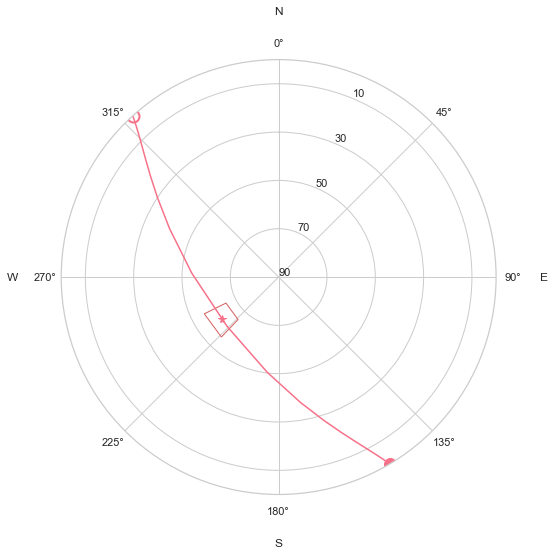

,Pass_number,AOS_time,LOS_time,Duration,MAX_azim,MAX_elev
0,1,2024-03-16T19:07:14.851843 UTC,2024-03-16T19:18:06.134892 UTC,0 days 00:10:51.283049,233.681366,60.675961


In [11]:
orbital_passes(tle_iss, create_station('Quezon City', (14.65,121.05,0)), 1,5, datetime(2024, 3, 16, 19, 7, 0), 20,10, fov_center=(233.681366, 60.675961))

A frame with the name 'Quezon City' is already registered. Overriding


    Time      Azim    Elev    Distance   Radial Velocity
AOS     19:07:14.851843 317.8638663087 0.0000004287     2360.824116    -6872.702932
        19:07:15.000000 317.8614911508 0.0091483441     2359.806008    -6872.673735
        19:07:20.000000 317.7799359031 0.3202357388     2325.445263    -6871.559707
        19:07:25.000000 317.6956012888 0.6359708792     2291.091003    -6870.187874
        19:07:30.000000 317.6083564756 0.9565685327     2256.743997    -6868.545576
        19:07:35.000000 317.5180643205 1.2822484107     2222.405907    -6866.619217
        19:07:40.000000 317.4245787825 1.6132435443     2188.078466    -6864.394152
        19:07:45.000000 317.3277418033 1.9498094690     2153.762653    -6861.854522
        19:07:50.000000 317.2273869958 2.2922093494     2119.460360    -6858.983258
        19:07:55.000000 317.1233366241 2.6407229661     2085.173567    -6855.761910
        19:08:00.000000 317.0153979554 2.9956566484     2050.903522    -6852.170424
        19:08:05.00

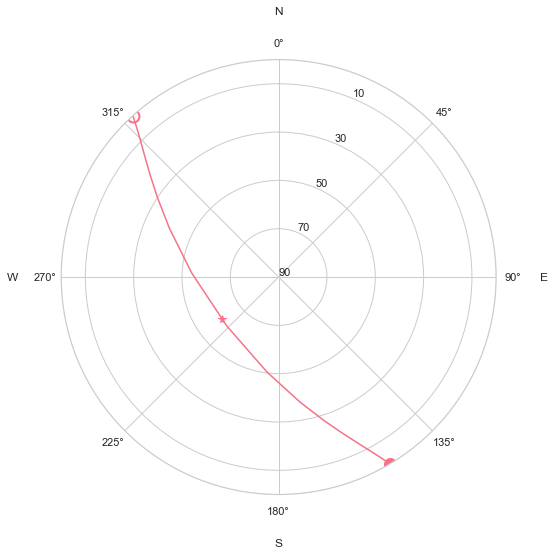

,Pass_number,AOS_time,LOS_time,Duration,MAX_azim,MAX_elev
0,1,2024-03-16T19:07:14.851843 UTC,2024-03-16T19:18:06.134892 UTC,0 days 00:10:51.283049,233.681366,60.675961


In [12]:
orbital_passes(tle_iss, create_station('Quezon City', (14.65,121.05,0)), 1,5, datetime(2024, 3, 16, 19, 7, 0), 0,0, fov_center=(233.681366, 60.675961))

**ISS SIMULATION AT QUEZON CITY ON MARCH 17, 2024**

                 Time        Azim       Elev    Distance  Radial Velocity  \
0     19:12:40.711713  233.681366  60.675961  480.020589        -2.394637   
1     19:12:40.712000  233.680861  60.675961  480.020588        -2.364815   
2     19:12:40.712500  233.679995  60.675961  480.020587        -2.313692   
3     19:12:40.713000  233.679057  60.675961  480.020586        -2.258309   
4     19:12:40.713500  233.678190  60.675961  480.020585        -2.207186   
...               ...         ...        ...         ...              ...   
2645  19:12:42.034000  231.310778  60.654604  480.109988       137.593007   
2646  19:12:42.034500  231.309841  60.654587  480.110060       137.648360   
2647  19:12:42.035000  231.308977  60.654572  480.110126       137.699454   
2648  19:12:42.035500  231.308112  60.654556  480.110193       137.750548   
2649  19:12:42.036000  231.307176  60.654539  480.110265       137.805900   

            s_ra     s_dec             X             Y           x         

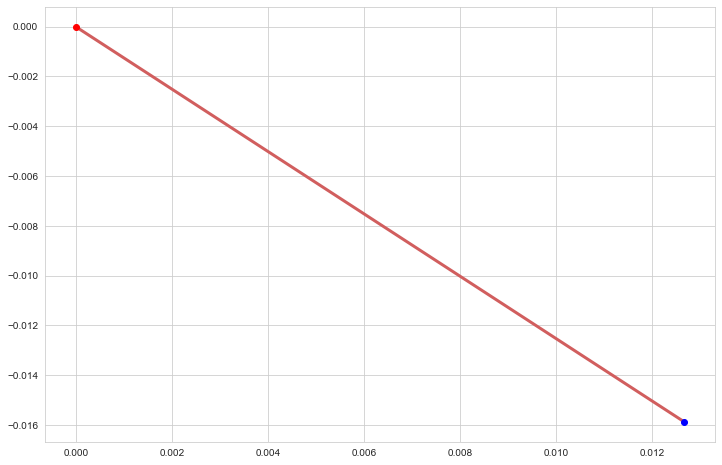

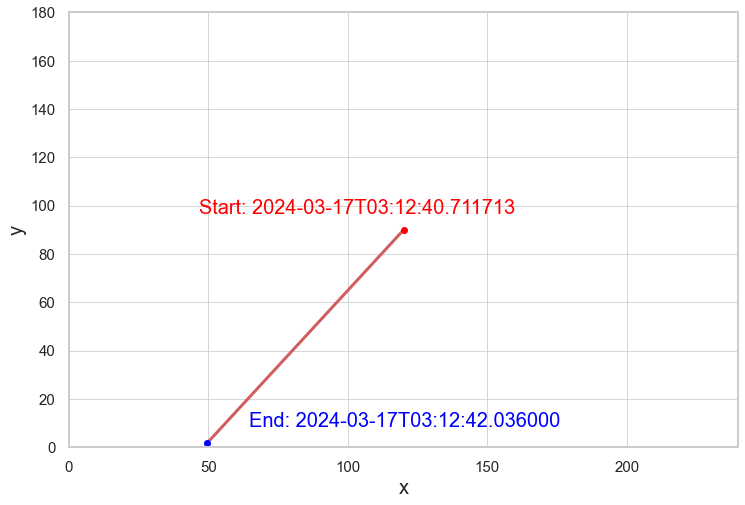

In [48]:
iss_passes_df = pd.read_csv('iss_passes_2.csv', delim_whitespace=True, dtype={'Time': str, 'Azim': float, 'Elev': float, 'Distance': float, 'Radial Velocity': float})
iss_passes_df.columns = ['Time', 'Azim', 'Elev', 'Distance', 'Radial Velocity', 'Extra']
iss_passes_df.drop(columns=['Extra'], inplace=True)

def calculate_coordinates(row):
    az = np.radians(row['Azim'])
    el = np.radians(row['Elev'])
    lon = np.radians(121.05)
    lat = np.radians(14.65)
    alt = row['Distance']
    ut = 2460386.296528
    J0 = ephem.julian_date(0)
    observer = ephem.Observer()
    observer.lon = lon
    observer.lat = lat
    observer.elevation = alt
    observer.date = ephem.date(ut - J0)
    ra, dec = observer.radec_of(az, el)
    s_ra = np.degrees(ra)
    s_dec = np.degrees(dec)

    # ra and dec to standard coordinates
    pxSize = 18  # microns
    widthPx = 240
    heightPx = 180
    c_ra = np.radians(199.050883)
    c_dec = np.radians(-3.323029)
    fLen = 2000  # mm
    bin = 20

    stdX = np.cos(np.radians(s_dec)) * np.sin(np.radians(s_ra) - c_ra) / (
        np.cos(c_dec) * np.cos(np.radians(s_dec)) * np.cos(np.radians(s_ra) - c_ra) + np.sin(c_dec) * np.sin(np.radians(s_dec)))
    stdY = -(np.sin(c_dec) * np.cos(np.radians(s_dec)) * np.cos(np.radians(s_ra) - c_ra) - np.cos(c_dec) * np.sin(np.radians(s_dec))) / (
        np.cos(c_dec) * np.cos(np.radians(s_dec)) * np.cos(np.radians(s_ra) - c_ra) + np.sin(c_dec) * np.sin(np.radians(s_dec)))

    # standard coordinates to pixel positions
    imageWidthRad = 2 * np.arctan((pxSize * bin * widthPx / 1000.0) / (2 * fLen))
    imageHeightRad = 2 * np.arctan((pxSize * bin * heightPx / 1000.0) / (2 * fLen))

    pixelsPerRadW = widthPx / imageWidthRad
    pixelsPerRadH = heightPx / imageHeightRad

    imageCenterX = widthPx / 2
    imageCenterY = heightPx / 2

    satPixelX = pixelsPerRadW * stdX + imageCenterX
    satPixelY = pixelsPerRadH * stdY + imageCenterY

    satPixelX = widthPx - satPixelX
    # satPixelY = heightPx - satPixelY

    return pd.Series({'s_ra': s_ra, 's_dec': s_dec, 'X': stdX, 'Y': stdY, 'x': satPixelX, 'y': satPixelY})

# Apply the function to each row of the DataFrame
iss_passes_df[['s_ra', 's_dec', 'X', 'Y', 'x', 'y']] = iss_passes_df.apply(calculate_coordinates, axis=1)
print(iss_passes_df)

# Plotting the standard coordinate system
plt.figure(figsize=(12, 8))
plt.plot(iss_passes_df['X'], iss_passes_df['Y'], color='#d15e5e', linewidth=3)
first_point_time = iss_passes_df.iloc[0]['Time']
last_point_time = iss_passes_df.iloc[-1]['Time']
first_point_x, first_point_y = iss_passes_df.iloc[0][['X', 'Y']]
last_point_x, last_point_y = iss_passes_df.iloc[-1][['X', 'Y']]

plt.plot(first_point_x, first_point_y, 'o', color='red')
plt.plot(last_point_x, last_point_y, 'o', color='blue')
plt.grid(True)
plt.show()

# Plotting the pixel coordinate system
plt.figure(figsize=(12, 8))
plt.plot(iss_passes_df['x'], iss_passes_df['y'], color='#d15e5e', linewidth=3)
first_point_time = iss_passes_df.iloc[0]['Time']
last_point_time = iss_passes_df.iloc[-1]['Time']
first_point_x, first_point_y = iss_passes_df.iloc[0][['x', 'y']]
last_point_x, last_point_y = iss_passes_df.iloc[-1][['x', 'y']]
plt.plot(first_point_x, first_point_y, 'o', color='red')
plt.plot(last_point_x, last_point_y, 'o', color='blue')
label_offset_x = 5
label_offset_z = 15
label_offset_y = 40
plt.text(first_point_x + label_offset_y, first_point_y + label_offset_x, "Start: 2024-03-17T03:12:40.711713", color='red', fontsize=20, ha='right', va='bottom')
plt.text(last_point_x + label_offset_z, last_point_y + label_offset_x, "End: 2024-03-17T03:12:42.036000", color='blue', fontsize=20, ha='left', va='bottom')
plt.xlim(0, 240)
plt.ylim(0, 180)
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=15, width=2, length=10)
plt.tick_params(axis='both', which='minor', labelsize=12, width=1.5, length=5)
ax = plt.gca()
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

plt.show()


**ABS-6 SIMULATION AT QUEZON CITY ON MARCH 16, 2024 to MARCH 17, 2024**

In [17]:
def orbital_passes(tle, station, hours, interval, specific_date, fov_horizontal, fov_vertical, fov_center=(0, 0)):
    passes_in_fov = []

    print("    Time      Azim    Elev    Distance   Radial Velocity")
    print("=========================================================")

    for orb in station.visibility(tle, start=specific_date, stop=timedelta(hours=hours), step=timedelta(seconds=interval), events=True):
        elev = np.degrees(orb.phi)
        azim = np.degrees(-orb.theta) % 360

        r = orb.r / 1000.
        print("{event:7} {orb.date:%H:%M:%S.%f} {azim:10.10f} {elev:10.10f} {r:15.6f} {orb.r_dot:15.6f}".format(
            orb=orb, r=r, azim=azim, elev=elev, event=orb.event.info if orb.event is not None else ""
        ))

        # Check if pass is within FOV
        if (fov_center[0] - fov_horizontal / 2) <= azim <= (fov_center[0] + fov_horizontal / 2) and (fov_center[1] - fov_vertical / 2) <= elev <= (fov_center[1] + fov_vertical / 2):
            passes_in_fov.append((orb.date, azim, elev, r)) 
            
    # Pass data
    df_passes = pd.DataFrame(passes_in_fov, columns=['timestamp', 'azim', 'elev','distance'])
    # sns.set(style="whitegrid", palette="muted")
    plt.figure(figsize=(10, 8))
    ax = plt.subplot(111, projection='polar')
    ax.set_theta_direction(-1)
    ax.set_theta_zero_location('N')
    ax.scatter(np.radians(df_passes['azim']), df_passes['elev'], s=20, marker='o', label='Pass') 

    # Rectangle patch
    fov_left = np.radians(fov_center[0] - fov_horizontal / 2)
    fov_bottom = 90 - (fov_center[1] + fov_vertical / 2)
    fov_width = np.radians(fov_horizontal)
    fov_height = fov_vertical
    fov_rect_patch = Rectangle((fov_left, fov_bottom), fov_width, fov_height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(fov_rect_patch)
    ax.set_aspect('equal', adjustable='box')
    
    ax.set_yticks(range(0, 90, 20))
    ax.set_yticklabels(map(str, range(90, 0, -20)))
    ax.set_rmax(90)
    label_distance = 110
    for angle, label in zip([0, 90, 180, 270], ['N', 'E', 'S', 'W']):
        ax.text(np.radians(angle), label_distance, label, ha='center', va='center') 
    # plt.show()

    passes_in_fov = pd.DataFrame(passes_in_fov, columns=["Time", "Azim", "Elev", "Distance"])

    # Iterate over each row and apply the ebs_projection function
    ra_deg_list = []
    dec_deg_list = []
    x_pixel_list = []
    y_pixel_list = []
    if not passes_in_fov.empty:
        for index, row in passes_in_fov.iterrows():
            s_ra, s_dec, x_pixel, y_pixel = ebs_projection(row['Azim'], row['Elev'], row['Distance'])
            ra_deg_list.append(s_ra)
            dec_deg_list.append(s_dec)
            x_pixel_list.append(x_pixel)
            y_pixel_list.append(y_pixel)

        passes_in_fov['RA_deg'] = ra_deg_list
        passes_in_fov['Dec_deg'] = dec_deg_list
        passes_in_fov['X_pixel'] = x_pixel_list
        passes_in_fov['Y_pixel'] = y_pixel_list

        plt.figure(figsize=(12, 8))
        # sns.set_style("whitegrid")
        plt.plot(passes_in_fov['X_pixel'], passes_in_fov['Y_pixel'], '-')
        plt.plot(passes_in_fov['X_pixel'].iloc[0], passes_in_fov['Y_pixel'].iloc[0], 'o', color = 'red',  markerfacecolor='none')
        plt.plot(passes_in_fov['X_pixel'].iloc[-1], passes_in_fov['Y_pixel'].iloc[-1], 'o', color = 'blue')

        label_offset_x = 5
        label_offset_y = 10
        plt.text(passes_in_fov['X_pixel'].iloc[0], passes_in_fov['Y_pixel'].iloc[0] - label_offset_y, "Start: 2024-03-16T08:00:00", color = 'red', fontsize=20, ha='right', va='bottom')
        plt.text(passes_in_fov['X_pixel'].iloc[-1] - label_offset_x, passes_in_fov['Y_pixel'].iloc[-1] + label_offset_y, "End: 2024-03-17T08:00:00", color='blue', fontsize=20, ha='left', va='bottom')
        plt.xlim(0, 240)
        plt.ylim(0, 180)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()
    else:
        print("No passes within FOV")

    return passes_in_fov


In [18]:
def ebs_projection(azim, elev, distance):  
    az = np.radians(azim) 
    el = np.radians(elev) 
    lon = np.radians(121.05) 
    lat = np.radians(14.65)
    alt = distance
    ut = 2460386.296528

    J0 = ephem.julian_date(0)

    observer = ephem.Observer()
    observer.lon = lon
    observer.lat = lat
    observer.elevation = alt
    observer.date = ephem.date(ut - J0)

    ra, dec = observer.radec_of(az, el)
    s_ra = np.degrees(ra)
    s_dec = np.degrees(dec)
    
    # ra and dec to standard coordinates
    pxSize = 18  # microns
    widthPx = 240
    heightPx = 180
    c_ra = np.radians(266.134902)
    c_dec = np.radians(-2.418167)
    fLen = 2000  # mm
    bin = 20

    stdX = np.cos(np.radians(s_dec)) * np.sin(np.radians(s_ra) - c_ra) / (
        np.cos(c_dec) * np.cos(np.radians(s_dec)) * np.cos(np.radians(s_ra) - c_ra) + np.sin(c_dec) * np.sin(np.radians(s_dec)))
    stdY = -(np.sin(c_dec) * np.cos(np.radians(s_dec)) * np.cos(np.radians(s_ra) - c_ra) - np.cos(c_dec) * np.sin(np.radians(s_dec))) / (
        np.cos(c_dec) * np.cos(np.radians(s_dec)) * np.cos(np.radians(s_ra) - c_ra) + np.sin(c_dec) * np.sin(np.radians(s_dec)))

    # standard coordinates to pixel positions
    imageWidthRad = 2 * np.arctan((pxSize * bin * widthPx / 1000.0) / (2 * fLen))
    imageHeightRad = 2 * np.arctan((pxSize * bin * heightPx / 1000.0) / (2 * fLen))

    pixelsPerRadW = widthPx / imageWidthRad
    pixelsPerRadH = heightPx / imageHeightRad

    imageCenterX = widthPx / 2
    imageCenterY = heightPx / 2

    satPixelX = pixelsPerRadW * stdX + imageCenterX
    satPixelY = pixelsPerRadH * stdY + imageCenterY

    satPixelX = widthPx - satPixelX
    # satPixelY = heightPx - satPixelY

    # Flipping the X coordinate
    satPixelX = widthPx - satPixelX
    
    return s_ra, s_dec, satPixelX, satPixelY


                  Time        Azim       Elev      Distance  Radial Velocity  \
0      00:00:00.000000  107.910898  43.414817  37513.066289         0.069685   
1      00:00:05.000000  107.910897  43.414804  37513.066625         0.070010   
2      00:00:10.000000  107.910896  43.414790  37513.066963         0.070334   
3      00:00:15.000000  107.910894  43.414777  37513.067303         0.070658   
4      00:00:20.000000  107.910893  43.414764  37513.067644         0.070983   
...                ...         ...        ...           ...              ...   
17277  23:59:40.000000  107.915930  43.411997  37513.262029         0.082911   
17278  23:59:45.000000  107.915929  43.411983  37513.262432         0.083231   
17279  23:59:50.000000  107.915928  43.411970  37513.262837         0.083552   
17280  23:59:55.000000  107.915926  43.411957  37513.263243         0.083873   
17281  00:00:00.000000  107.915925  43.411944  37513.263651         0.084194   

             s_ra     s_dec            

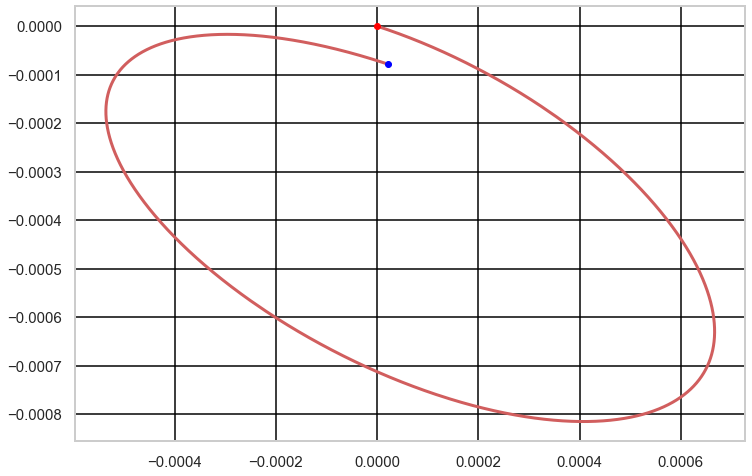

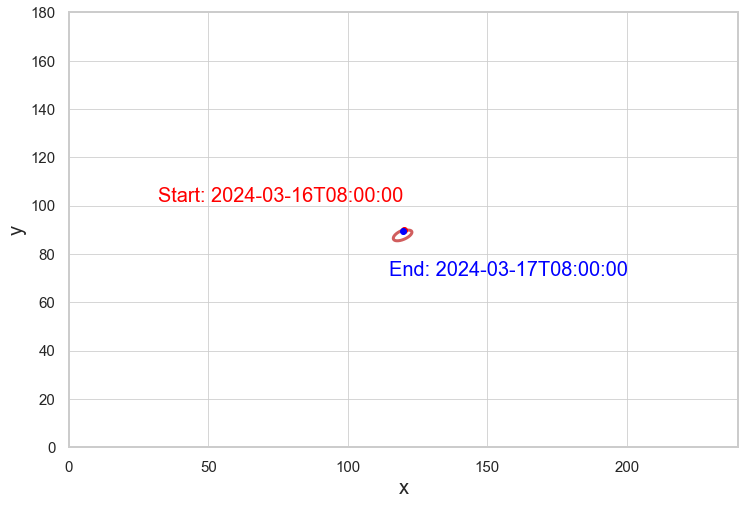

In [47]:

iss_passes_df = pd.read_csv('iss_passes.csv', delim_whitespace=True, dtype={'Time': str, 'Azim': float, 'Elev': float, 'Distance': float, 'Radial Velocity': float})
iss_passes_df.columns = ['Time', 'Azim', 'Elev', 'Distance', 'Radial Velocity', 'Extra']
iss_passes_df.drop(columns=['Extra'], inplace=True)

def calculate_coordinates(row):
    az = np.radians(row['Azim'])
    el = np.radians(row['Elev'])
    lon = np.radians(121.05)
    lat = np.radians(14.65)
    alt = row['Distance']
    ut = 2460386.296528
    J0 = ephem.julian_date(0)
    observer = ephem.Observer()
    observer.lon = lon
    observer.lat = lat
    observer.elevation = alt
    observer.date = ephem.date(ut - J0)
    ra, dec = observer.radec_of(az, el)
    s_ra = np.degrees(ra)
    s_dec = np.degrees(dec)

    # ra and dec to standard coordinates
    pxSize = 18  # microns
    widthPx = 240
    heightPx = 180
    c_ra = np.radians(266.134902)
    c_dec = np.radians(-2.418167)
    fLen = 2000  # mm
    bin = 20

    stdX = np.cos(np.radians(s_dec)) * np.sin(np.radians(s_ra) - c_ra) / (
        np.cos(c_dec) * np.cos(np.radians(s_dec)) * np.cos(np.radians(s_ra) - c_ra) + np.sin(c_dec) * np.sin(np.radians(s_dec)))
    stdY = -(np.sin(c_dec) * np.cos(np.radians(s_dec)) * np.cos(np.radians(s_ra) - c_ra) - np.cos(c_dec) * np.sin(np.radians(s_dec))) / (
        np.cos(c_dec) * np.cos(np.radians(s_dec)) * np.cos(np.radians(s_ra) - c_ra) + np.sin(c_dec) * np.sin(np.radians(s_dec)))

    # standard coordinates to pixel positions
    imageWidthRad = 2 * np.arctan((pxSize * bin * widthPx / 1000.0) / (2 * fLen))
    imageHeightRad = 2 * np.arctan((pxSize * bin * heightPx / 1000.0) / (2 * fLen))

    pixelsPerRadW = widthPx / imageWidthRad
    pixelsPerRadH = heightPx / imageHeightRad

    imageCenterX = widthPx / 2
    imageCenterY = heightPx / 2

    satPixelX = pixelsPerRadW * stdX + imageCenterX
    satPixelY = pixelsPerRadH * stdY + imageCenterY

    satPixelX = widthPx - satPixelX
    # satPixelY = heightPx - satPixelY

    return pd.Series({'s_ra': s_ra, 's_dec': s_dec, 'X': stdX, 'Y': stdY, 'x': satPixelX, 'y': satPixelY})

# Apply the function to each row of the DataFrame
iss_passes_df[['s_ra', 's_dec', 'X', 'Y', 'x', 'y']] = iss_passes_df.apply(calculate_coordinates, axis=1)
print(iss_passes_df)


# Plotting standard coordinate system
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))
plt.plot(iss_passes_df['X'], iss_passes_df['Y'], color='#d15e5e', linewidth=3) 

first_point_time = iss_passes_df.iloc[0]['Time']
last_point_time = iss_passes_df.iloc[-1]['Time']
first_point_x, first_point_y = iss_passes_df.iloc[0][['X', 'Y']]
last_point_x, last_point_y = iss_passes_df.iloc[-1][['X', 'Y']]

plt.plot(first_point_x, first_point_y, 'o', color='red')
plt.plot(last_point_x, last_point_y, 'o', color='blue')
plt.grid(True, color='black', linestyle='-', linewidth=1.5) 
plt.tick_params(axis='both', which='major', labelsize=15, width=2, length=10)
plt.tick_params(axis='both', which='minor', labelsize=12, width=1.5, length=5)
ax = plt.gca()
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

plt.show()

# Plotting pixel cooridnate system
plt.figure(figsize=(12, 8))
plt.plot(iss_passes_df['x'], iss_passes_df['y'], color='#d15e5e', linewidth=3)  # Thicker line

first_point_time = iss_passes_df.iloc[0]['Time']
last_point_time = iss_passes_df.iloc[-1]['Time']
first_point_x, first_point_y = iss_passes_df.iloc[0][['x', 'y']]
last_point_x, last_point_y = iss_passes_df.iloc[-1][['x', 'y']]

plt.plot(first_point_x, first_point_y, 'o', color='red')
plt.plot(last_point_x, last_point_y, 'o', color='blue')

label_offset_x = 5
label_offset_z = 10
label_offset_y = 20
plt.text(first_point_x, first_point_y + label_offset_z, "Start: 2024-03-16T08:00:00", color = 'red', fontsize=20, ha='right', va='bottom')
plt.text(last_point_x - label_offset_x, last_point_y - label_offset_y, "End: 2024-03-17T08:00:00", color='blue', fontsize=20, ha='left', va='bottom')

plt.xlim(0, 240)
plt.ylim(0, 180)
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=15, width=2, length=10)
plt.tick_params(axis='both', which='minor', labelsize=12, width=1.5, length=5)
ax = plt.gca()
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

plt.show()

